In [1]:
import os
import fiona
import joypy
import matplotlib
import geopandas as gp

import pandas as pd
import numpy as np
import rasterio as rio
import scipy.interpolate as interp
import matplotlib.pyplot as plt

from mpl_toolkits.basemap import Basemap
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from matplotlib.lines import Line2D
from matplotlib.collections import PatchCollection
from matplotlib.patches import Polygon
from shapely.geometry import Polygon as shPolygon

from osgeo import gdal
from tqdm import tqdm
from matplotlib import gridspec
from datetime import datetime, timedelta
from rasterio import features, mask
from IPython.display import HTML
from dateutil.relativedelta import relativedelta
from mpl_toolkits.basemap import Basemap
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable

matplotlib.rcParams['animation.embed_limit'] = 2**128

In [2]:
def draw_polys(gdf, mpl_map, facecolor = "red",  alpha = 0.3, edgecolor = 'black', lw = 1, fill = True, zorder = 3):
    
    '''
    Turns a geopandas gdf of multipolygons into matplotlib polygon patches for friendly plotting with basemap. 
    '''
    
    for index, row in gdf.iterrows():
        lats = []
        lons = []
        for pt in list(row['geometry'].exterior.coords): 
            lats.append(pt[1])
            lons.append(pt[0])

        x, y = m( lons, lats )
        xy = zip(x,y)
        poly = Polygon(list(xy), fc=facecolor, alpha=alpha, ec = edgecolor ,lw = lw, fill = fill, zorder = zorder)
        plt.gca().add_patch(poly)

    return


def draw_points(gdf, mpl_map, sizecol = None, color = 'red', alpha = 0.7, edgecolor = None, fill = True, zorder = 4):
    '''
    Turns a geopandas gdf of points into matplotlib lat/lon objects for friendly plotting with basemap. 
    '''
    lats = []
    lons = []
    for index, row in gdf.iterrows():
         for pt in list(row['geometry'].coords): 
            lats.append(pt[1])
            lons.append(pt[0])
    
    if sizecol is None:
        sizecol = 50
    else:
        sizecol = sizecol.values
    
    m.scatter(lons, lats, latlon=True, s = sizecol, alpha=alpha, c = color, edgecolor = edgecolor, zorder = zorder)


In [3]:
# Read files

reservoirs = gp.read_file('../shape/term_res.shp')
catchments = gp.read_file('../shape/sierra_catchments.shp')
cv = gp.read_file('/Users/aakash/Desktop/HyDRA/shape/cv.shp')

lagim = rio.open("../rasters/SNODAS_dswe_gte0/lag.tif").read(1)
lagim[lagim==0] = np.nan

sweim = rio.open("../rasters/SNODAS_dswe_gte0/swe.tif").read(1)
sweim[sweim==0] = np.nan

corim = rio.open("../rasters/SNODAS_dswe_gte0/cor.tif").read(1)
corim[corim==0] = np.nan

# get bbox of data 
imextent = rio.open("../rasters/SNODAS_dswe_gte0/lag.tif").bounds
lllon, lllat = imextent[0], imextent[1]
urlon, urlat = imextent[2], imextent[3]


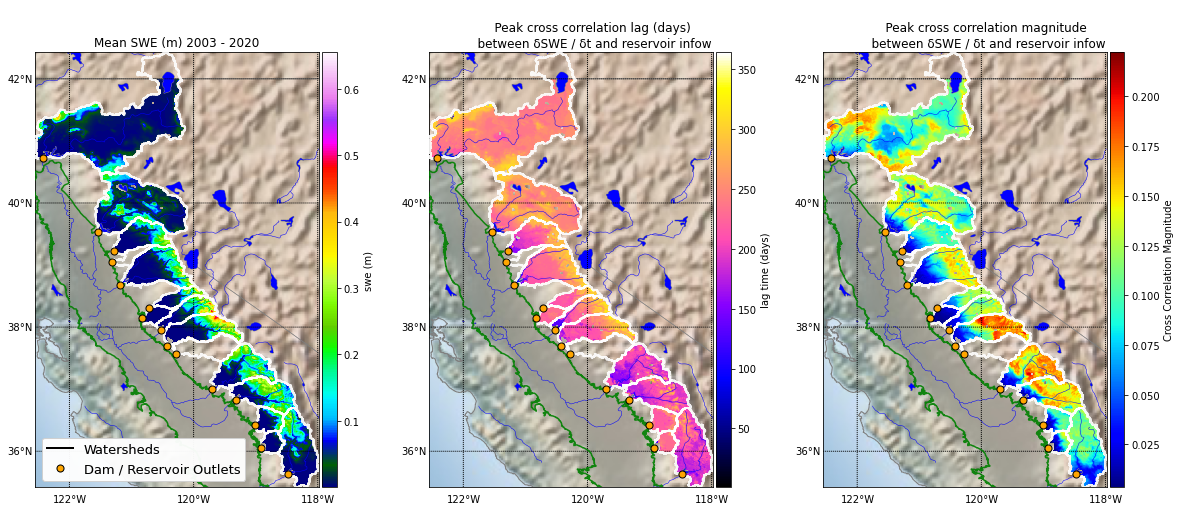

In [4]:
fig = plt.figure(figsize=(20,8))


############################## First Map: SWe 
ax1 = fig.add_subplot(131)
# Initialize the basemap
m = Basemap(ax = ax1,epsg='4326', ellps='WGS84',resolution='f', llcrnrlon=lllon, urcrnrlon=urlon, llcrnrlat=lllat, urcrnrlat=urlat,
            lat_0= (lllat + urlat) / 2, lon_0= (lllon + urlon) / 2)

# Add stuff to basemap 
m.shadedrelief(zorder = 0)
m.drawcoastlines(color='gray', zorder = 2)
m.drawcountries(color='gray', zorder = 2)
m.drawstates(color='gray', zorder = 2)
m.drawrivers(color = "blue", zorder = 2)
m.fillcontinents(color='none',lake_color='blue', zorder = 2)

# Draw lines of latitude and longitude. Labels are like [left,right,top,bottom]
parallels = np.arange(0.,90.,2.)
meridians = np.arange(0.,360.,2.)

m.drawparallels(parallels,labels=[True,False,True,False]) # [left,right,top,bottom]
m.drawmeridians(meridians,labels=[True,False,False,True]) # [left,right,top,bottom]

# Draw the watersheds we delineated
draw_polys(catchments, m, alpha = 0.9, edgecolor = 'white', lw = 1.5, fill = False)
draw_points(reservoirs,m, alpha = 1,  color= 'orange', edgecolor = 'black')
draw_polys(cv, m, alpha = 0.9, edgecolor = 'green', lw = 1.5, fill = False)

# Plot im
im = m.imshow(np.flipud(sweim), cmap='gist_ncar')
ax1.set_title("Mean SWE (m) 2003 - 2020")

# Set location of the colorbar
divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(mappable=im, cax=cax, label='swe (m)')

# Make the first legend (upper left of map)
custom_lines = [Line2D([0], [0], color='black', lw=2),
                Line2D([0], [0], linewidth=0, marker='o', markersize=7, 
                       markeredgecolor = 'black',markerfacecolor="orange"),
                ]

leg1 = ax1.legend(custom_lines, ["Watersheds", 'Dam / Reservoir Outlets'],
                    loc = "lower left",
                    prop={'size':13})

ax1.add_artist(leg1)

############################## Second Map: Lagtimes 

ax2 = fig.add_subplot(132)
# Initialize the basemap
m = Basemap(ax = ax2,epsg='4326', ellps='WGS84',resolution='f', llcrnrlon=lllon, urcrnrlon=urlon, llcrnrlat=lllat, urcrnrlat=urlat,
            lat_0= (lllat + urlat) / 2, lon_0= (lllon + urlon) / 2)

# Add stuff to basemap 
m.shadedrelief(zorder = 0)
m.drawcoastlines(color='gray', zorder = 2)
m.drawcountries(color='gray', zorder = 2)
m.drawstates(color='gray', zorder = 2)
m.drawrivers(color = "blue", zorder = 2)
m.fillcontinents(color='none',lake_color='blue', zorder = 2)

# Draw lines of latitude and longitude. Labels are like [left,right,top,bottom]
parallels = np.arange(0.,90.,2.)
meridians = np.arange(0.,360.,2.)

m.drawparallels(parallels,labels=[True,False,True,False]) # [left,right,top,bottom]
m.drawmeridians(meridians,labels=[True,False,False,True]) # [left,right,top,bottom]

# Draw the watersheds we delineated
draw_polys(catchments, m, alpha = 0.9, edgecolor = 'white', lw = 1.5, fill = False)
draw_points(reservoirs,m, alpha = 1,  color= 'orange', edgecolor = 'black')
draw_polys(cv, m, alpha = 0.9, edgecolor = 'green', lw = 1.5, fill = False)

# Plot im
im = m.imshow(np.flipud(lagim), cmap='gnuplot2')
ax2.set_title('''
            Peak cross correlation lag (days) 
            between δSWE / δt and reservoir infow''')

# Set location of the colorbar
divider = make_axes_locatable(ax2)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(mappable=im, cax=cax, label='lag time (days)')

############################## 3rd Map: Corr Magnitudes  

ax3 = fig.add_subplot(133)
# Initialize the basemap
m = Basemap(ax = ax3,epsg='4326', ellps='WGS84',resolution='f', llcrnrlon=lllon, urcrnrlon=urlon, llcrnrlat=lllat, urcrnrlat=urlat,
            lat_0= (lllat + urlat) / 2, lon_0= (lllon + urlon) / 2)

# Add stuff to basemap 
m.shadedrelief(zorder = 0)
m.drawcoastlines(color='gray', zorder = 2)
m.drawcountries(color='gray', zorder = 2)
m.drawstates(color='gray', zorder = 2)
m.drawrivers(color = "blue", zorder = 2)
m.fillcontinents(color='none',lake_color='blue', zorder = 2)

# Draw lines of latitude and longitude. Labels are like [left,right,top,bottom]
parallels = np.arange(0.,90.,2.)
meridians = np.arange(0.,360.,2.)

m.drawparallels(parallels,labels=[True,False,True,False]) # [left,right,top,bottom]
m.drawmeridians(meridians,labels=[True,False,False,True]) # [left,right,top,bottom]

# Draw the watersheds we delineated
draw_polys(catchments, m, alpha = 0.9, edgecolor = 'white', lw = 1.5, fill = False)
draw_points(reservoirs,m, alpha = 1,  color= 'orange', edgecolor = 'black')
draw_polys(cv, m, alpha = 0.9, edgecolor = 'green', lw = 1.5, fill = False)

# Plot im
im = m.imshow(np.flipud(corim), cmap='jet')
ax3.set_title('''
            Peak cross correlation magnitude 
            between δSWE / δt and reservoir infow''')

# Set location of the colorbar
divider = make_axes_locatable(ax3)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(mappable=im, cax=cax, label='Cross Correlation Magnitude')

# Joyplots

In [5]:
catchments['ctrlat'] = catchments.centroid.geometry.y
catchments = catchments.sort_values('ctrlat', ascending = False)

In [6]:
mdf = []

for idx, shed in catchments.iterrows():

    # Read shapefile
    shppath = os.path.join("../shape", shed['stid'] + ".shp")
    with fiona.open(shppath, "r") as shapefile:
        area_geom = [feature["geometry"] for feature in shapefile]
    
    swe_fn = '../rasters/SNODAS_dswe_gte0/swe.tif'
    swe_src = rio.open(swe_fn) # Read file
    swe_masked = rio.mask.mask(swe_src, area_geom, crop=True) # Clip to shp 
    swe_m = swe_masked[0].astype(float) # read as array
    swe_arr = swe_m[0,:,:]
    swe_arr[swe_arr < 0.05 ] = np.nan # Mask nodata vals 
    swe_arr[swe_arr > 0.5 ] = np.nan
    
    lag_fn = '../rasters/SNODAS_dswe_gte0/lag.tif'
    lag_src = rio.open(lag_fn) # Read file
    lag_masked = rio.mask.mask(lag_src, area_geom, crop=True) # Clip to shp 
    lag_m = lag_masked[0].astype(float) # read as array
    lag_arr = lag_m[0,:,:]
    lag_arr[lag_arr < 2 ] = np.nan # Mask nodata vals 
    
    cor_fn = '../rasters/SNODAS_dswe_gte0/cor.tif'
    cor_src = rio.open(cor_fn) # Read file
    cor_masked = rio.mask.mask(cor_src, area_geom, crop=True) # Clip to shp 
    cor_m = cor_masked[0].astype(float) # read as array
    cor_arr = cor_m[0,:,:]
    cor_arr[swe_arr > 0.5 ] = np.nan
    
    data = [swe_arr.flatten(), lag_arr.flatten(), cor_arr.flatten()]
    
    shed_df = pd.DataFrame(data).T
    shed_df.columns = ['swe','lag','cor']
    shed_df['shed'] = shed['stid']
                 
    mdf.append(shed_df)

<ipython-input-6-4a3a3383a279>:15: RuntimeWarning: invalid value encountered in less
  swe_arr[swe_arr < 0.05 ] = np.nan # Mask nodata vals
<ipython-input-6-4a3a3383a279>:16: RuntimeWarning: invalid value encountered in greater
  swe_arr[swe_arr > 0.5 ] = np.nan
<ipython-input-6-4a3a3383a279>:23: RuntimeWarning: invalid value encountered in less
  lag_arr[lag_arr < 2 ] = np.nan # Mask nodata vals
<ipython-input-6-4a3a3383a279>:30: RuntimeWarning: invalid value encountered in greater
  cor_arr[swe_arr > 0.5 ] = np.nan


/anaconda3/envs/pysheds/lib/python3.8/site-packages/joypy/joyplot.py:224: UserWarning: At least a column/group has no numeric values.
  warn("At least a column/group has no numeric values.")


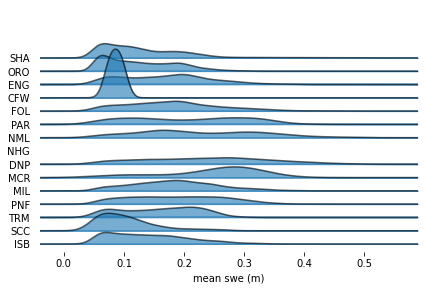

In [7]:
grouped = pd.concat(mdf).groupby("shed", sort=False)
fig, axes = joypy.joyplot(grouped, column="swe", alpha = 0.6)
plt.xlabel("mean swe (m)")
plt.ylabel('watershed')
plt.show()

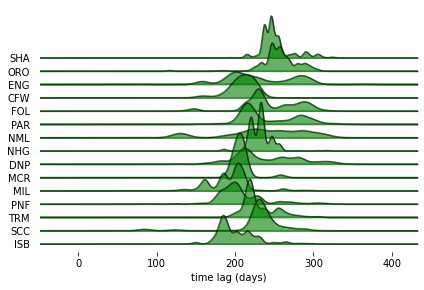

In [8]:
grouped = pd.concat(mdf).groupby("shed", sort=False)
fig, axes = joypy.joyplot(grouped, column="lag", color = 'g', alpha = 0.6)
plt.xlabel("time lag (days)")
plt.ylabel('watershed')
plt.show()

# Travel Time

In [9]:
# Clip the rasters to the watershed boundaries 

for idx, x in enumerate(catchments[:].iterrows()):
    print(idx)
    print("****" * 15)

    row  = x[1]
    stn_id = row['stid']
    print(stn_id, row['catch_name'])
    
    # Setup dirs 
    outdir = "../rasters/flow_dist"
    dfn = os.path.join(outdir,"{}_dist.tif".format(stn_id))
    # Clip rasters to shp 
    catch_shp = "../shape/{}.shp".format(stn_id)
    
    outfn = dfn[:-4] + "_cl.tif"
    
    if not os.path.exists(outfn):
        cmd = '''gdalwarp -cutline {} -crop_to_cutline -dstalpha {} {}'''.format(catch_shp, dfn, outfn)
        print(cmd)
        os.system(cmd) 
    else:
        continue

0
************************************************************
SHA SACRAMENTO R
1
************************************************************
ORO FEATHER R
2
************************************************************
ENG YUBA R
3
************************************************************
CFW BEAR R
4
************************************************************
FOL AMERICAN R
5
************************************************************
PAR MOKELUMNE R
6
************************************************************
NML STANISLAUS R
7
************************************************************
NHG CALAVERAS R
8
************************************************************
DNP TUOLUMNE R
9
************************************************************
MCR MERCED R
10
************************************************************
MIL SAN JOAQUIN R
11
************************************************************
PNF KINGS R
12
************************************************************
TRM

# Cd to dirs and run from cmd line:

### To merge:
```gdal_merge.py -n 0 -o dist.tif *dist_cl.tif```

### To resample:
```gdalwarp -t_srs EPSG:4326 -tr 0.000833333333333 0.00083333333333 -r near -te -122.5483333 35.4191667 -117.9833333 42.4283333 -te_srs EPSG:4326 -of GTiff lag.tif lag_resamp.tif```

In [10]:
lagim_rs = rio.open("../rasters/SNODAS_dswe_gte0/lag_resamp.tif").read(1)
distim = rio.open("../rasters/flow_dist/dist.tif").read(1)
lagim_rs[lagim_rs==0] = np.nan
distim[distim==0] = np.nan
distim = distim*90 # convert n px to m

In [11]:
ttim = distim/lagim_rs

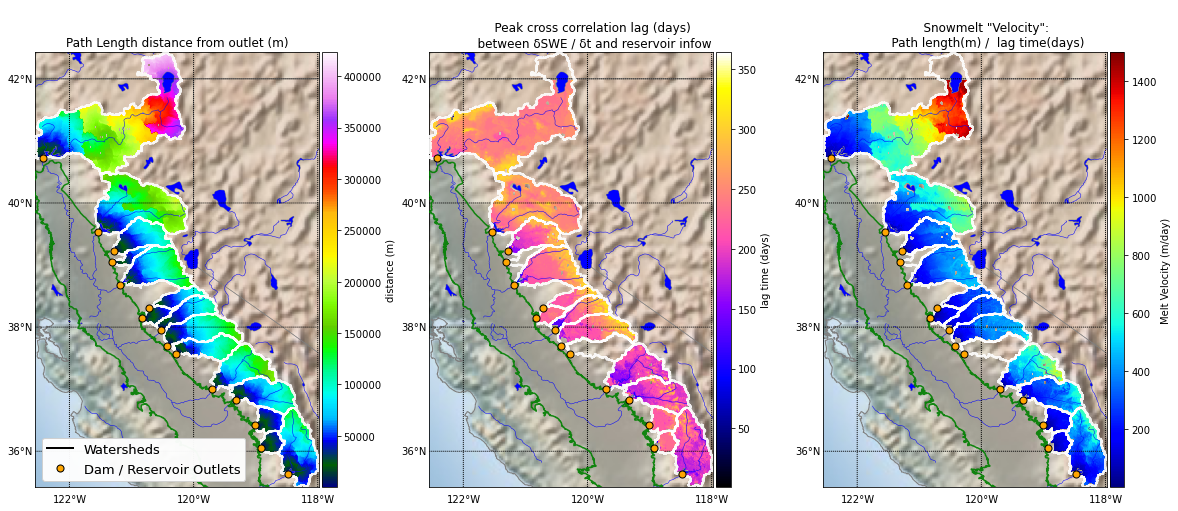

In [12]:
fig = plt.figure(figsize=(20,8))

############################## First Map
ax1 = fig.add_subplot(131)
# Initialize the basemap
m = Basemap(ax = ax1,epsg='4326', ellps='WGS84',resolution='f', llcrnrlon=lllon, urcrnrlon=urlon, llcrnrlat=lllat, urcrnrlat=urlat,
            lat_0= (lllat + urlat) / 2, lon_0= (lllon + urlon) / 2)

# Add stuff to basemap 
m.shadedrelief(zorder = 0)
m.drawcoastlines(color='gray', zorder = 2)
m.drawcountries(color='gray', zorder = 2)
m.drawstates(color='gray', zorder = 2)
m.drawrivers(color = "blue", zorder = 2)
m.fillcontinents(color='none',lake_color='blue', zorder = 2)

# Draw lines of latitude and longitude. Labels are like [left,right,top,bottom]
parallels = np.arange(0.,90.,2.)
meridians = np.arange(0.,360.,2.)

m.drawparallels(parallels,labels=[True,False,True,False]) # [left,right,top,bottom]
m.drawmeridians(meridians,labels=[True,False,False,True]) # [left,right,top,bottom]

# Draw the watersheds we delineated
draw_polys(catchments, m, alpha = 0.9, edgecolor = 'white', lw = 1.5, fill = False)
draw_points(reservoirs,m, alpha = 1,  color= 'orange', edgecolor = 'black')
draw_polys(cv, m, alpha = 0.9, edgecolor = 'green', lw = 1.5, fill = False)

# Plot im
im = m.imshow(np.flipud(distim), cmap='gist_ncar')
ax1.set_title("Path Length distance from outlet (m)")

# Set location of the colorbar
divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(mappable=im, cax=cax, label='distance (m)')

# Make the first legend (upper left of map)
custom_lines = [Line2D([0], [0], color='black', lw=2),
                Line2D([0], [0], linewidth=0, marker='o', markersize=7, 
                       markeredgecolor = 'black',markerfacecolor="orange"),
                ]

leg1 = ax1.legend(custom_lines, ["Watersheds", 'Dam / Reservoir Outlets'],
                    loc = "lower left",
                    prop={'size':13})

ax1.add_artist(leg1)

############################## Second Map

ax2 = fig.add_subplot(132)
# Initialize the basemap
m = Basemap(ax = ax2,epsg='4326', ellps='WGS84',resolution='f', llcrnrlon=lllon, urcrnrlon=urlon, llcrnrlat=lllat, urcrnrlat=urlat,
            lat_0= (lllat + urlat) / 2, lon_0= (lllon + urlon) / 2)

# Add stuff to basemap 
m.shadedrelief(zorder = 0)
m.drawcoastlines(color='gray', zorder = 2)
m.drawcountries(color='gray', zorder = 2)
m.drawstates(color='gray', zorder = 2)
m.drawrivers(color = "blue", zorder = 2)
m.fillcontinents(color='none',lake_color='blue', zorder = 2)

# Draw lines of latitude and longitude. Labels are like [left,right,top,bottom]
parallels = np.arange(0.,90.,2.)
meridians = np.arange(0.,360.,2.)

m.drawparallels(parallels,labels=[True,False,True,False]) # [left,right,top,bottom]
m.drawmeridians(meridians,labels=[True,False,False,True]) # [left,right,top,bottom]

# Draw the watersheds we delineated
draw_polys(catchments, m, alpha = 0.9, edgecolor = 'white', lw = 1.5, fill = False)
draw_points(reservoirs,m, alpha = 1,  color= 'orange', edgecolor = 'black')
draw_polys(cv, m, alpha = 0.9, edgecolor = 'green', lw = 1.5, fill = False)

# Plot im
im = m.imshow(np.flipud(lagim_rs), cmap='gnuplot2')
ax2.set_title('''
            Peak cross correlation lag (days) 
            between δSWE / δt and reservoir infow''')

# Set location of the colorbar
divider = make_axes_locatable(ax2)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(mappable=im, cax=cax, label='lag time (days)')

############################## 3rd Map

ax3 = fig.add_subplot(133)
# Initialize the basemap
m = Basemap(ax = ax3,epsg='4326', ellps='WGS84',resolution='f', llcrnrlon=lllon, urcrnrlon=urlon, llcrnrlat=lllat, urcrnrlat=urlat,
            lat_0= (lllat + urlat) / 2, lon_0= (lllon + urlon) / 2)

# Add stuff to basemap 
m.shadedrelief(zorder = 0)
m.drawcoastlines(color='gray', zorder = 2)
m.drawcountries(color='gray', zorder = 2)
m.drawstates(color='gray', zorder = 2)
m.drawrivers(color = "blue", zorder = 2)
m.fillcontinents(color='none',lake_color='blue', zorder = 2)

# Draw lines of latitude and longitude. Labels are like [left,right,top,bottom]
parallels = np.arange(0.,90.,2.)
meridians = np.arange(0.,360.,2.)

m.drawparallels(parallels,labels=[True,False,True,False]) # [left,right,top,bottom]
m.drawmeridians(meridians,labels=[True,False,False,True]) # [left,right,top,bottom]

# Draw the watersheds we delineated
draw_polys(catchments, m, alpha = 0.9, edgecolor = 'white', lw = 1.5, fill = False)
draw_points(reservoirs,m, alpha = 1,  color= 'orange', edgecolor = 'black')
draw_polys(cv, m, alpha = 0.9, edgecolor = 'green', lw = 1.5, fill = False)

# Plot im
im = m.imshow(np.flipud(ttim), cmap='jet', vmax = 1500)
ax3.set_title('''
            Snowmelt "Velocity": 
            Path length(m) /  lag time(days)''')

# Set location of the colorbar
divider = make_axes_locatable(ax3)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(mappable=im, cax=cax, label='Melt Velocity (m/day)')